In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np

In [2]:
import random

def set_seed(seed=777):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(777)

In [3]:
!pip install torchvision 

In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image

class RoomsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
from torch.utils.data import DataLoader

train_dataset = RoomsDataset(
    data_dir='../../splitted_dataset/train',
    transform=train_transforms
)

val_dataset = RoomsDataset(
    data_dir='../../splitted_dataset/val',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
import torchvision.models as models


class RoomClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes=4, freeze_backbone=True):
        super().__init__()

        # Load pretrained ResNet18
        self.base_model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)

        # Freeze all parameters initially if desired
        if freeze_backbone:
            for param in self.base_model.parameters():
                param.requires_grad = False
        
        # Replace the final classifier
        in_features = self.base_model.classifier[1].in_features  # 1280 for B1
        
        # New classifier head
        self.base_model.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),  # Keep the same dropout as original
            #nn.Linear(in_features, num_classes)
            nn.Dropout(0.4),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # Unfreeze only the new classifier
        for param in self.base_model.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.base_model(x)

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
import os

train_dir = "../../splitted_dataset/train"

class_names = sorted(os.listdir(train_dir))
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

labels = []
for cls in class_names:
    labels += [class_to_idx[cls]] * len(os.listdir(f"{train_dir}/{cls}"))

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)

Class weights: tensor([1.0925, 0.6295, 1.3696, 1.3056])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RoomClassifierEfficientNet(num_classes=4)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(
    model.base_model.classifier.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /Users/stan/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth


100.0%


In [10]:
# Training loop
num_epochs = 50
best_val_acc = 0
no_improve_in_a_row = 0

for epoch in range(num_epochs):
    if no_improve_in_a_row >= 5:
        print("Hardstop because no improvements")
        break

    # -------- TRAIN --------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # -------- CHECKPOINT --------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_name = f"best_model_epoch_{epoch + 1}.pth"
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_acc
        }, best_model_name)

        no_improve_in_a_row = 0
        print(f"✅ New best model saved (Val Acc: {val_acc:.4f})")
    else:
        no_improve_in_a_row += 1

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Acc: {val_acc:.4f}")


✅ New best model saved (Val Acc: 0.7583)
Epoch 1/50
  Train Loss: 0.8437, Acc: 0.6307
  Val Loss:   0.5841, Acc: 0.7583
✅ New best model saved (Val Acc: 0.7601)
Epoch 2/50
  Train Loss: 0.6165, Acc: 0.7338
  Val Loss:   0.5749, Acc: 0.7601
✅ New best model saved (Val Acc: 0.7638)
Epoch 3/50
  Train Loss: 0.5609, Acc: 0.7775
  Val Loss:   0.5659, Acc: 0.7638
✅ New best model saved (Val Acc: 0.7712)
Epoch 4/50
  Train Loss: 0.5026, Acc: 0.7922
  Val Loss:   0.5413, Acc: 0.7712
Epoch 5/50
  Train Loss: 0.4945, Acc: 0.7906
  Val Loss:   0.5697, Acc: 0.7638
✅ New best model saved (Val Acc: 0.7749)
Epoch 6/50
  Train Loss: 0.4675, Acc: 0.8038
  Val Loss:   0.5531, Acc: 0.7749
Epoch 7/50
  Train Loss: 0.4563, Acc: 0.8148
  Val Loss:   0.5871, Acc: 0.7657
✅ New best model saved (Val Acc: 0.7897)
Epoch 8/50
  Train Loss: 0.4313, Acc: 0.8101
  Val Loss:   0.5581, Acc: 0.7897
Epoch 9/50
  Train Loss: 0.3807, Acc: 0.8432
  Val Loss:   0.5432, Acc: 0.7860
Epoch 10/50
  Train Loss: 0.4154, Acc: 0.83

In [11]:
model = RoomClassifierEfficientNet(num_classes=4) 

checkpoint = torch.load(best_model_name, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

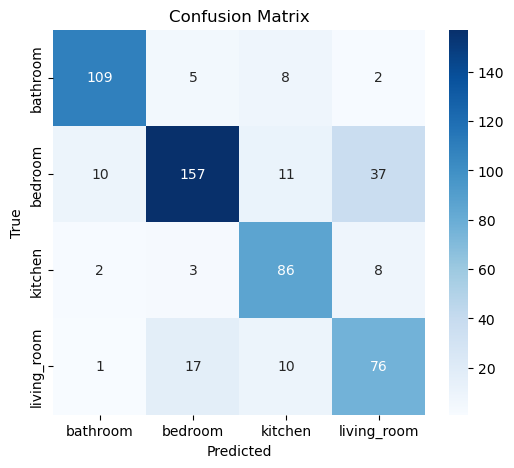

In [13]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [14]:
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names
))

              precision    recall  f1-score   support

    bathroom       0.89      0.88      0.89       124
     bedroom       0.86      0.73      0.79       215
     kitchen       0.75      0.87      0.80        99
 living_room       0.62      0.73      0.67       104

    accuracy                           0.79       542
   macro avg       0.78      0.80      0.79       542
weighted avg       0.80      0.79      0.79       542



In [16]:
# Unfreeze for fine-tuning
for name, param in model.base_model.features.named_parameters():
    if "6" in name or "7" in name:
        param.requires_grad = True

optimizer = torch.optim.AdamW(
    [
        {"params": model.base_model.features.parameters(), "lr": 1e-4},
        {"params": model.base_model.classifier.parameters(), "lr": 1e-3},
    ],
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=20,
    eta_min=1e-6
)

num_epochs = 15
no_improve_in_a_row = 0

In [17]:
for epoch in range(num_epochs):

    if no_improve_in_a_row >= 3:
        print("Hardstop because no improvements")
        break

    # ===== TRAIN =====
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # -------- LR SCHEDULER --------
    scheduler.step()

    # ===== SAVE BEST MODEL =====
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_acc
        }, "best_model.pth")

        no_improve_in_a_row = 0
        print(f"✅ New best model saved (Val Acc: {val_acc:.4f})")
    else:
        no_improve_in_a_row += 1

    print(f"""
Epoch {epoch+1}/{num_epochs}
Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}
Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}
""")


Epoch 1/15
Train Loss: 0.4051, Train Acc: 0.8222
Val Loss:   0.5088, Val Acc:   0.7768

✅ New best model saved (Val Acc: 0.8173)

Epoch 2/15
Train Loss: 0.3097, Train Acc: 0.8790
Val Loss:   0.4448, Val Acc:   0.8173

✅ New best model saved (Val Acc: 0.8395)

Epoch 3/15
Train Loss: 0.2133, Train Acc: 0.9185
Val Loss:   0.4301, Val Acc:   0.8395


Epoch 4/15
Train Loss: 0.1720, Train Acc: 0.9379
Val Loss:   0.4480, Val Acc:   0.8376


Epoch 5/15
Train Loss: 0.1124, Train Acc: 0.9548
Val Loss:   0.4801, Val Acc:   0.8284

✅ New best model saved (Val Acc: 0.8506)

Epoch 6/15
Train Loss: 0.1136, Train Acc: 0.9579
Val Loss:   0.4731, Val Acc:   0.8506


Epoch 7/15
Train Loss: 0.0880, Train Acc: 0.9642
Val Loss:   0.4564, Val Acc:   0.8395


Epoch 8/15
Train Loss: 0.0761, Train Acc: 0.9726
Val Loss:   0.4545, Val Acc:   0.8487

✅ New best model saved (Val Acc: 0.8635)

Epoch 9/15
Train Loss: 0.0747, Train Acc: 0.9737
Val Loss:   0.4454, Val Acc:   0.8635


Epoch 10/15
Train Loss: 0.0510, Tr

In [18]:
!pip install onnxscript

In [19]:
model = RoomClassifierEfficientNet(num_classes=4) 

checkpoint = torch.load("best_model.pth", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

dummy_input = torch.randn(1, 3, 224, 224)
onnx_path = "room_classifier_efficientnetb0_tunned.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print("Model successfully exported to room_classifier_efficientnetb0_tunned.onnx")

/var/folders/pd/fx9stk756697jx8_ft4b76080000gp/T/ipykernel_26695/3381862550.py:10: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `RoomClassifierEfficientNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `RoomClassifierEfficientNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 140 of general pattern rewrite rules.
Model successfully exported to room_classifier_efficientnetb0_tunned.onnx


Launch on test folder of dataset

In [20]:
model = RoomClassifierEfficientNet(num_classes=4)
checkpoint = torch.load("best_model.pth", map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

RoomClassifierEfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
    

In [21]:
test_dataset = RoomsDataset(
    data_dir='../../splitted_dataset/test',
    transform=val_transforms
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [23]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8727


In [24]:
print(classification_report(
    all_labels,
    all_preds,
    target_names=test_dataset.classes
))

              precision    recall  f1-score   support

    bathroom       0.98      0.94      0.96        63
     bedroom       0.86      0.88      0.87       109
     kitchen       0.85      0.94      0.90        50
 living_room       0.79      0.72      0.75        53

    accuracy                           0.87       275
   macro avg       0.87      0.87      0.87       275
weighted avg       0.87      0.87      0.87       275



In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
best_val_acc